# Theory of AI Performance Gap

In [408]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp
from sympy import latex
import seaborn as sns

In [409]:
# default parameters used throughout our theoretical analysis

# flop_year_zero = 1e19

dollar_to_flop = 1e17
alg_gains_train = 1.8 # improvement in algorithmic compute efficency each year
alg_gains = alg_gains_train
hardware_gains = 1.4 #increase in GPU Flops/dollar each year
sota_compute_growth = 5 # model compute budget grows five fold each year
inference_cost = .000143 # cost per inference in dollars
alg_gains_inf = 4 # improvement in algorithmic compute efficency each year for inference
cost_per_flop_year = 0.8
start_capital = 1000
flop_year_zero = start_capital*dollar_to_flop


In [410]:

#kaplan version
# C0 = 1e8
# alpha = -0.05
# chin_func = lambda c: 1.69+(c/C0)**(alpha)


#chinchilla version 
chin_func = lambda c: 1070*c**(-0.154)+1.7
total_loss = lambda base_flop, time: chin_func(
    (alg_gains**time)*base_flop/(cost_per_flop_year**time)
)
#make lambda function into regular function
def loss_full_function(init_compute, time, alg_gains=alg_gains_train, hardware_gains=hardware_gains, investment_growth=1):
    return chin_func(
        (alg_gains**time)*init_compute*(investment_growth**time)* (hardware_gains**time)
    )

# loss for model with given inference cost
# total_loss_inf = lambda base_flops, time: chin_func(
#     (
#         ((base_flops)**2)/ (cost_per_flop_year**(2*time))
#         * (alg_gains**time)*(alg_gains_inf**time)
      
#     )
# )
def total_loss_inf(init_compute, time):
    effective_training_compute = init_compute * (hardware_gains**time)
    effective_inference_compute = effective_training_compute**2 * (alg_gains_inf**time)*(alg_gains**time)
    return chin_func(effective_inference_compute)


Peak overhang occurs at 4.4 years


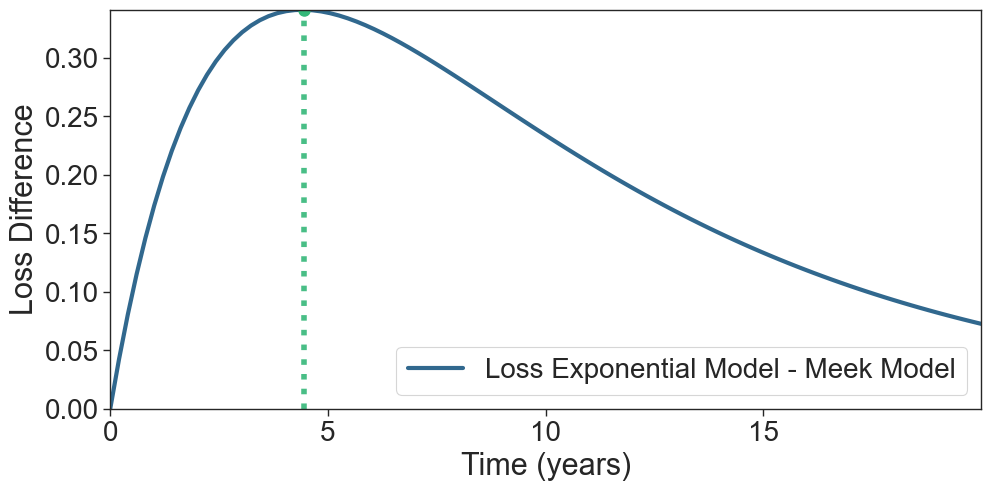

In [411]:
# Plot of overhang over time

sns.set_style("ticks")
sns.set_context("paper")

time = np.linspace(0, 20, 100)
f = plt.figure(figsize=(10, 5))
colors = sns.color_palette("viridis", n_colors=2)
# gs = f.add_gridspec(5, 5)
top_model_loss = total_loss(flop_year_zero * (sota_compute_growth) ** time, time)
basic_model_loss = total_loss(flop_year_zero, time)

# Calculate loss difference and find maximum point
loss_diff = basic_model_loss - top_model_loss
max_idx = np.argmax(loss_diff)
max_time = time[max_idx]
max_loss_diff = loss_diff[max_idx]
# plt.rcParams['font.family'] = 'DejaVu Sans'
sns.lineplot(x=time, y=loss_diff, label="Loss Exponential Model - Meek Model", linewidth=3,color=colors[0])

# Add vertical line at maximum point
plt.axvline(x=max_time, color=colors[1], linestyle=':', alpha=0.9, linewidth=4)
plt.plot(max_time, max_loss_diff, 'o', color=colors[1], markersize=8)  # Add orange dot at peak
# plt.annotate('peak overhang', xy=(max_time, max_loss_diff), xytext=(max_time-1, max_loss_diff-0.55), 
#             fontsize=20)
# add description 
print(f"Peak overhang occurs at {max_time:.1f} years")
# plt.title("AI Model Training Inequality Over Time",fontweight='bold', fontsize=15)
plt.xlabel("Time (years)", fontsize=22)
# plt.legend(fontsize=14, loc='lower right')
plt.ylabel("Loss Difference", fontsize=22)
#adjust font sizes
plt.xticks(np.arange(0, 20, 5),fontsize=20)
plt.yticks(fontsize=20)
plt.legend(prop={'size': 20}, loc='lower right')
#adjust label sizes
plt.margins(0,0)
plt.tight_layout()

plt.savefig("Figures/overhang.png")

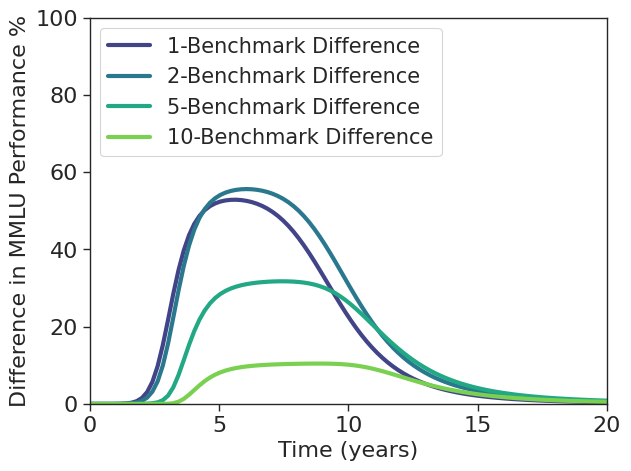

In [412]:
# Benchmark Performance of the Model 
# L = 0.5566859825577314
# x0 = 1.9739480423345785
# k = -23.774928114776312
# b = 0.2540434458699578
consecutive_tasks = 5
small_p = 2

colors = sns.color_palette("viridis", n_colors=4)
def loss_to_benchmark(x, k=-23.77, x0=1.97, L=0.55, b=0.25):
    return L/(1 + np.exp(-k*(x-x0))) + b
    # return 1/(1+np.exp(1*(x-1.97)))
sns.set_style("ticks")
sns.set_context("paper")
time = np.linspace(0, 20, 100)
y1 = loss_to_benchmark(total_loss(flop_year_zero * (sota_compute_growth) ** time, time))
y2 = loss_to_benchmark(total_loss(flop_year_zero, time))
y4 = y2-y1
y3 = y2**consecutive_tasks-y1**consecutive_tasks
y5 = y2**small_p-y1**small_p
y10 = y2**10-y1**10
# plt.plot(x, y1, label='sigmoid(x)')
# plt.plot(x, y2, label='sigmoid(2*x)')
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.xticks(np.arange(0, 21, 5), fontsize=16)
plt.plot(time, -y4*100, label='1-Benchmark Difference', linewidth=3, color=colors[0])
plt.plot(time, -y5*100, label=f'{small_p}-Benchmark Difference', linewidth=3, color=colors[1])
plt.plot(time, -y3*100, label=f'{consecutive_tasks}-Benchmark Difference', linewidth=3, color=colors[2])
plt.plot(time, -y10*100, label=f'10-Benchmark Difference', linewidth=3, color=colors[3])
# plt.legend(loc='center', bbox_to_anchor=(0.5, -0.2), ncol=3, fontsize=12)
plt.legend(loc='upper left', fontsize=15)

plt.yticks(fontsize=16)
plt.xscale('linear')
plt.xlabel("Time (years)", fontsize=16)
plt.ylabel("Difference in MMLU Performance %", fontsize=16)
plt.ylim(0, 100)
plt.xticks(np.arange(0, 21, 5), fontsize=16)
# plt.grid(True)
plt.margins(0,0)
plt.tight_layout()

plt.savefig("Figures/benchmark_performance.png")

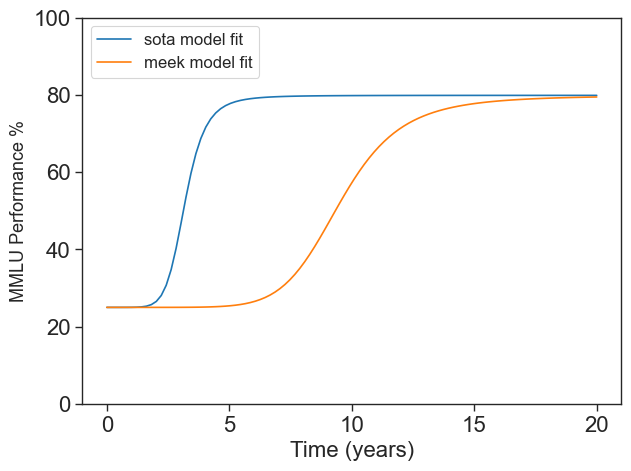

In [413]:

consecutive_tasks = 5
small_p = 2
sns.set_style("ticks")
sns.set_context("paper")



time = np.linspace(0, 20, 100)
y1 = loss_to_benchmark(total_loss(flop_year_zero * (sota_compute_growth) ** time, time))
y2 = loss_to_benchmark(total_loss(flop_year_zero, time))
plt.plot(time, y1*100, label='sota model fit')
plt.plot(time, y2*100, label='meek model fit')
# plt.plot(x, y1, label='sigmoid(x)')
# plt.plot(x, y2, label='sigmoid(2*x)')

# plt.legend(loc='center', bbox_to_anchor=(0.5, -0.2), ncol=3, fontsize=12)
plt.legend(loc='upper left', fontsize=12)

plt.yticks(fontsize=16)
plt.xscale('linear')
plt.xlabel("Time (years)", fontsize=16)
plt.ylabel("MMLU Performance %", fontsize=13)
plt.ylim(0, 100)
plt.xticks(np.arange(0, 21, 5), fontsize=16)
# plt.grid(True)
plt.tight_layout()
plt.savefig("Figures/logistic_loss_comparison.png")

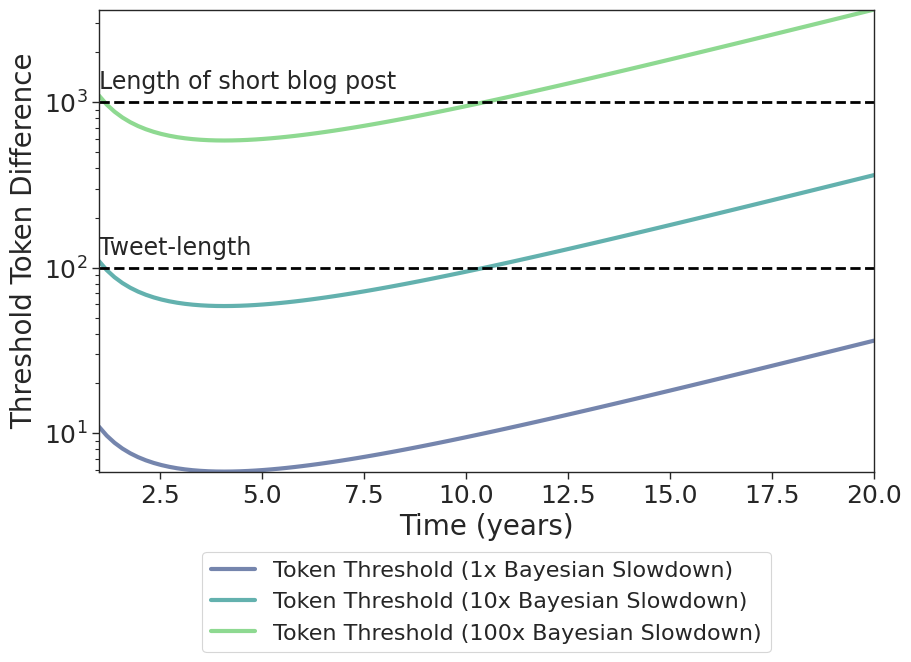

In [414]:
# now look at upper and lower bounds based on TV divergence 
# epsilon = 1e-2 # lower bound on error of hypothesis testing
slowdowns = [1, 10, 100]
colors = sns.color_palette("viridis", n_colors=3)
D1 = lambda time: loss_full_function(1e19, time, investment_growth=1)-1.7
D2 = lambda time: loss_full_function(1e19, time, investment_growth=5)-1.7
# upper_bound = lambda time, slowdown: slowdown*2*(1-epsilon)**2*((D1(time)/2)-(D2(time)/2))**-1
upper_bound = lambda time, slowdown: slowdown*2.65*((D1(time)-D2(time))**-1)

x = np.linspace(1, 20, 100)
plt.figure(figsize=(10, 6))
plt.rcParams['font.family'] = 'DejaVu Sans'
for i, slowdown in enumerate(slowdowns):
    y_upper = upper_bound(x, slowdown)
    plt.plot(x, y_upper, label=f"Token Threshold ({slowdown}x Bayesian Slowdown)", linewidth=3, alpha=0.7, color=colors[i])

plt.axhline(y=1e3, color='black', linestyle='--', linewidth=2)
plt.text(1, 1.2e3, 'Length of short blog post', fontsize=17)

plt.axhline(y=1e2, color='black', linestyle='--', linewidth=2)
plt.text(1, 1.2e2, 'Tweet-length', fontsize=17)

plt.xlabel("Time (years)", fontsize=20)
plt.ylabel("Threshold Token Difference", fontsize=20)
# plt.grid(True)
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.legend(fontsize=16, bbox_to_anchor=(0.5, -0.15), loc='upper center')
# plt.title("Number of Tokens Necessary to Distinguish Models for Various Slowdowns", fontsize=14, fontweight='bold')
plt.yscale('log')
plt.margins(0,0)
plt.savefig("Figures/growth_token_distinction_boundary.png", bbox_inches='tight')


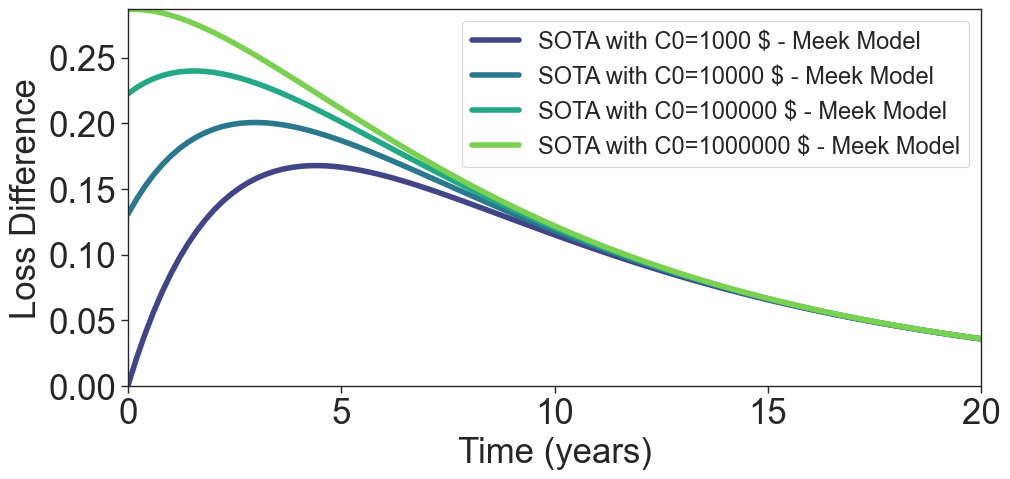

In [415]:
#part of robustness analysis look at different starting captial scenarios

sns.set_style("ticks")
sns.set_context("paper")
# Plot of overhang over time
time = np.linspace(0, 20, 100)
colors = sns.color_palette("viridis", n_colors=4)
# i want them all to be on the same graph
dollar_to_flop = 1e19
plt.figure(figsize=(10, 5))
for i, start_capital in enumerate([1000, 10000, 100000, 1000000]):
    basic_capital = 1000
    # sota_compute_growth = 5 # model compute is growing at 5 times a year 
    # player2_growth = 1.1
    sota_loss = total_loss(start_capital*dollar_to_flop * (sota_compute_growth) ** time, time)
    basic_model_loss = total_loss(basic_capital*dollar_to_flop, time)
    plt.plot(
        time,  basic_model_loss-sota_loss, label=f"SOTA with C0={start_capital} $ - Meek Model", linewidth=4, color=colors[i])
# add description 
#adjust font sizes
plt.xticks(np.arange(0, 21, 5),fontsize=25)
plt.yticks(fontsize=25)
plt.legend(prop={'size': 14})
# add description to plot
# plt.title("Variation of Initial Top Model Investment", fontsize=14)
plt.xlabel("Time (years)",fontsize=25)
plt.legend(fontsize=17)
plt.ylabel("Loss Difference",fontsize=25)
# plt.grid(True)
#save image to paper images
# extended_colors
plt.tight_layout()
plt.margins(0,0)
plt.savefig("Figures/variation_initial_investment.png")


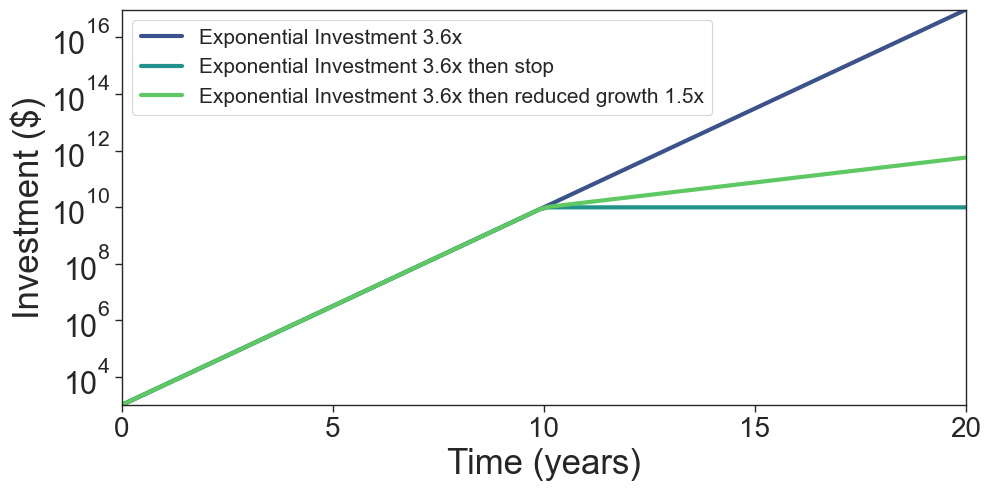

In [416]:
# look at different investment curves over time for top model 
#ie regular exponential 
#logistic
#exponential then stop 
#exponential then reduced exponential growth
sns.set_style("ticks")
sns.set_context("paper")
colors = sns.color_palette("viridis", n_colors=3)
time = np.linspace(0, 20, 100)
plt.figure(figsize=(10, 5))

# logistic_investment = lambda time: 1000 + 1e10/ (1 + 1e11*np.exp(-np.log(5)* (time+5)))
# exponential_investment = lambda time: 1000.0 * (sota_compute_growth) ** time
# exponential_stop_investment = lambda time: 1000.0 * (sota_compute_growth) ** time if time < 5 else 1000.0 * (5) ** 5
#map exponential investment onto time array
# exponential_stop_investment = list(map(exponential_stop_investment, time))
stop_time = 10
exponential_stop_investment = np.where(time <= stop_time, 1000.0 * (sota_compute_growth) ** time, 1000.0 * (5) ** stop_time)
exponential_reduce_investment = lambda time: 1000.0 * (sota_compute_growth) ** time if time < stop_time else 1000.0 * (sota_compute_growth) ** stop_time * (1.5) ** (time-stop_time)
exponential_reduce_investment = list(map(exponential_reduce_investment, time))
exponential_investment = 1000.0 * (sota_compute_growth) ** time
#map exponential reduce investment onto time array

# plt.plot(time, logistic_investment(time), label="Logistic Investment")
plt.plot(time, exponential_investment, label="Exponential Investment 3.6x ", linewidth=3, color=colors[0])
plt.plot(time, exponential_stop_investment, label="Exponential Investment 3.6x then stop", linewidth=3, color=colors[1])
plt.plot(time, exponential_reduce_investment, label="Exponential Investment 3.6x then reduced growth 1.5x", linewidth=3, color=colors[2])
plt.yscale("log")
# plt.grid(True)
plt.legend(fontsize=15)
plt.xticks(np.arange(0, 21, 5),fontsize=20)
plt.yticks(fontsize=22)
plt.xlabel("Time (years)", fontsize=25)
plt.ylabel("Investment ($)", fontsize=25)
# plt.title("Investment Schedules", fontsize=20)
plt.margins(0,0)
plt.tight_layout()
plt.savefig("Figures/variation_investment_curves.png")

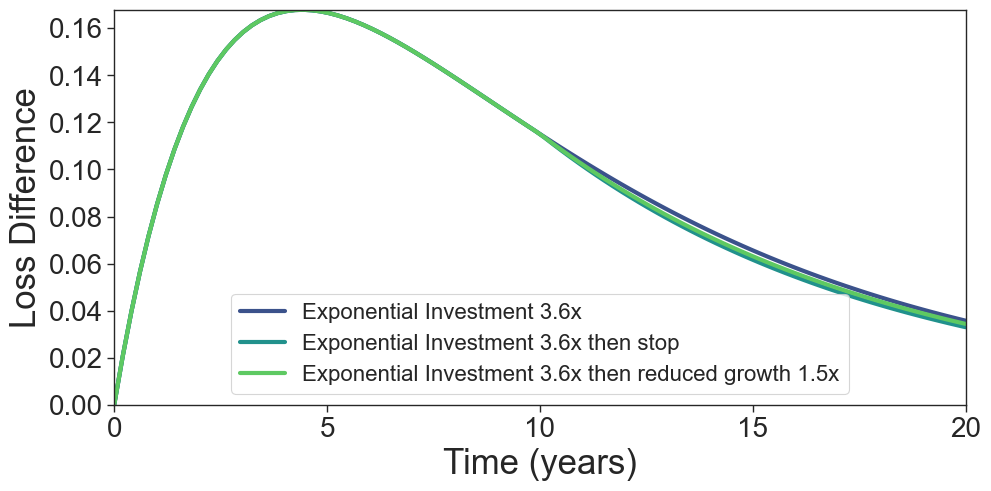

In [417]:
#now look at model trends under each of these investment scenarios

sns.set_style("ticks")
sns.set_context("paper")
time = np.linspace(0, 20, 100)
colors = sns.color_palette("viridis", n_colors=3)

# Convert investment arrays to numpy arrays for element-wise multiplication
exponential_stop_investment = np.array(exponential_stop_investment)
exponential_reduce_investment = np.array(exponential_reduce_investment)

loss_diff_exponential = -(total_loss(dollar_to_flop*exponential_investment, time) - total_loss(1000*dollar_to_flop, time))

loss_diff_exponential_stop = -(total_loss(dollar_to_flop*exponential_stop_investment, time) - total_loss(1000.0*dollar_to_flop, time))

loss_diff_exponential_reduce = -(total_loss(dollar_to_flop*exponential_reduce_investment, time) - total_loss(1000*dollar_to_flop, time))
plt.figure(figsize=(10, 5))
plt.plot(time, loss_diff_exponential, label="Exponential Investment 3.6x", linewidth=3, color=colors[0])
plt.plot(time, loss_diff_exponential_stop, label="Exponential Investment 3.6x then stop", linewidth=3, color=colors[1])
plt.plot(time, loss_diff_exponential_reduce, label="Exponential Investment 3.6x then reduced growth 1.5x", linewidth=3, color=colors[2])
plt.legend(fontsize=16)
plt.xlabel("Time (years)", fontsize=25)
plt.ylabel("Loss Difference", fontsize=25)
# plt.grid(True)
plt.xticks(np.arange(0, 21, 5), fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("Time (years)", fontsize=25)
plt.margins(0,0)
plt.tight_layout()
plt.savefig("Figures/variation_investment_curves_loss_diff.png")


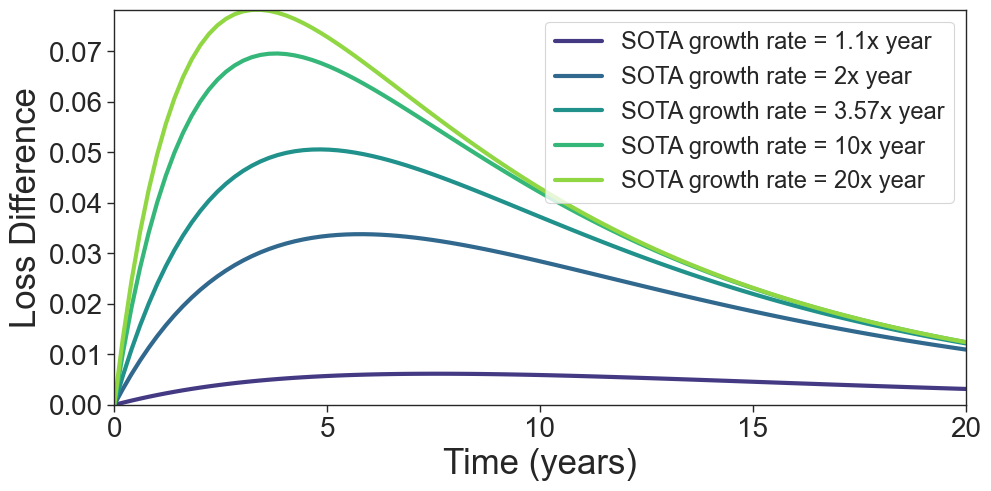

In [418]:
#model configuring various levels of compute growth 
#first look at variation with variation in shared growth factor 

sns.set_style("ticks")
sns.set_context("paper")
time = np.linspace(0, 20, 100)
plt.figure(figsize=(10,5))
colors = sns.color_palette("viridis", n_colors=5)
for i, sota_compute_growth in enumerate([1.1, 2, 3.57, 10, 20]):
    # both models start with an initial captial of 1000 dollars
    sota_loss = total_loss(start_capital*dollar_to_flop * (sota_compute_growth) ** time, time)
    basic_model_loss = total_loss(start_capital*dollar_to_flop, time)
    plt.plot(
        time, basic_model_loss - sota_loss, label=f"SOTA growth rate = {sota_compute_growth}x year", linewidth=3, color=colors[i])
# add description 
# add description to plot
# plt.title("Variation of Initial Top Model Investment", fontsize=14)
plt.xlabel("Time (years)", fontsize=25)
plt.ylabel("Loss Difference", fontsize=25)
#adjust font sizes
plt.xticks(np.arange(0, 21, 5),fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=17)
plt.margins(0,0)
# plt.setp(plt.gca().spines.values(), color='#CCD8D9')
# plt.grid('major', color='#F2F6F6', zorder=0)
# plt.tick_params(axis='both', which='both', color='#CCD8D9')
plt.tight_layout()
#save image to paper images
plt.savefig("Figures/variation_sota_growth.png")
plt.show()


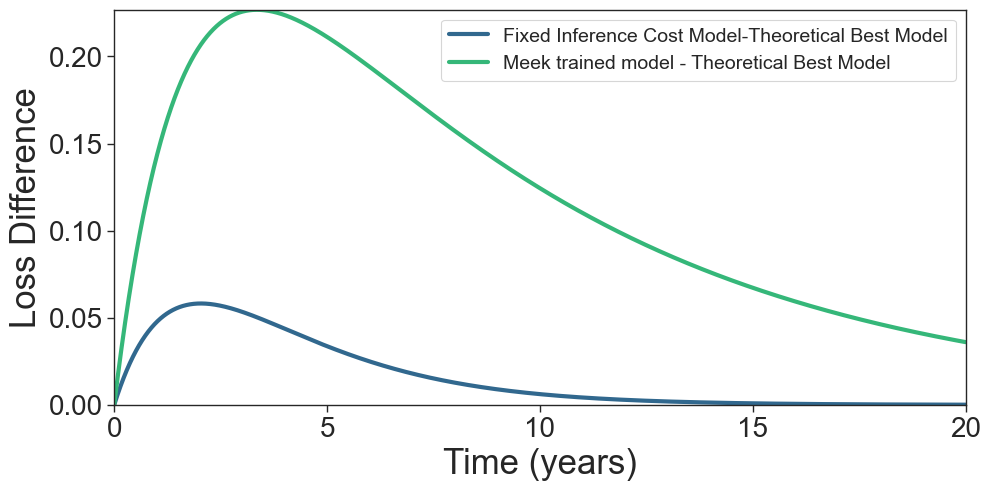

In [419]:
sns.set_style("ticks")
sns.set_context("paper")
#Model of Inference Inequality Over Time
base_inference_cost = 0.00000001
#this is equal to 1e-8
time = np.linspace(0, 20, 10000)
colors = sns.color_palette("viridis", n_colors=2)
start_capital = 1000
# Plot inference overhang and training overhang at the same time
sota_loss = total_loss(start_capital* dollar_to_flop * (sota_compute_growth) ** time, time)
basic_loss = total_loss(start_capital*dollar_to_flop, time)
# computer inference cost of model that uses 1000 dollars of training
# infcost0 = 
plt.figure(figsize=(10, 5))
plt.plot(time, total_loss_inf(base_inference_cost*dollar_to_flop, time)- sota_loss, label="Fixed Inference Cost Model-Theoretical Best Model", linewidth=3, color=colors[0])
plt.plot(time, basic_loss-sota_loss, label="Meek trained model - Theoretical Best Model", linewidth=3, color=colors[1])
plt.xlabel("Time (years)", fontsize=25)
plt.ylabel("Loss Difference", fontsize=25)
plt.xticks(np.arange(0, 21, 5), fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=14)
# plt.title("Inference vs Training Inequality Over Time", fontsize=14)
# plt.grid(True)
plt.margins(0,0)
plt.tight_layout()
plt.savefig("Figures/loss_diff_inference.png")
plt.show()


In [420]:
# import matplotlib.pyplot as plt
# import numpy as np

# # Assuming total_loss, start_capital, and sota_compute_growth are defined
# plt.rcParams['font.family'] = 'Helvetica'
# # Plot of overhang over time
# time = np.linspace(0, 20, 100)
# # Adjust figure size for a typical dual-column width (~3.5 inches wide)
# plt.figure(figsize=(3.5, 2.5))
# top_model_loss = total_loss(start_capital * (sota_compute_growth) ** time, time)
# capital_time = start_capital * (sota_compute_growth) ** time
# basic_model_loss = total_loss(start_capital, time)
# # Calculate loss difference and find maximum point
# loss_diff = basic_model_loss - top_model_loss
# max_idx = np.argmax(loss_diff)
# max_time = time[max_idx]
# max_loss_diff = loss_diff[max_idx]

# # Find point where capital reaches 1e8 (assuming target is 1e8 based on annotation text)
# # target_capital = 1e8
# # time_point = np.argmin(np.abs(capital_time - target_capital))
# # plt.scatter(time[time_point], loss_diff[time_point], color='blue', s=20, zorder=5) # Reduced marker size slightly
# # Adjust annotation font size and positioning for smaller figure, keep annotation text bold
# # plt.annotate(f'top-model capital: {capital_time[time_point]:.1e} $', xy=(time[time_point], loss_diff[time_point]), xytext=(time[time_point]+0.5, loss_diff[time_point]),
# #             fontsize=8) # Keep annotation text bold for emphasis

# plt.plot(time, loss_diff, label="Loss Exponential Model - Meak Model", linewidth=1.5) # Slightly thinner line

# # Add vertical line at maximum point
# plt.axvline(x=max_time, color='r', linestyle=':', alpha=0.9, linewidth=1.5) # Slightly thinner line
# plt.plot(max_time, max_loss_diff, 'ro', markersize=4, zorder=5, alpha=0.8)  # Add red dot at peak, adjusted marker size
# # Adjust annotation font size and positioning for smaller figure, keep annotation text bold
# plt.annotate('peak overhang', xy=(max_time, max_loss_diff), xytext=(max_time+0.5, max_loss_diff-0.1),
#             fontsize=10) # Keep annotation text bold for emphasis


# # add description
# print(f"Best Exponential Model growth: {sota_compute_growth} times a year, it starts out with {start_capital} dollars, we assume consumer starts out with capital of {start_capital} dollars") # Corrected consumer capital assumption based on basic_model_loss
# print(f"Peak overhang occurs at {max_time:.1f} years")

# # Adjust title and label font sizes for smaller figure, remove bold from labels
# plt.title("AI Model Training Inequality Over Time", fontweight='bold', fontsize=10) # Keep title bold
# plt.xlabel("Time (years)", fontsize=9) # Removed bold
# plt.ylabel("Log Likelihood Loss Difference", fontsize=9) # Removed bold

# # Make grid lines more subtle
# plt.grid(True, alpha=0.5, linestyle='--') # More transparent and dashed grid

# # Adjust tick font sizes for smaller figure, remove bold from ticks
# plt.xticks(fontsize=8) # Removed bold
# plt.yticks(fontsize=8) # Removed bold

# # Adjust legend font size and location, remove bold from legend text
# plt.legend(prop={'size': 8}, loc='lower right') # Removed bold from prop

# plt.tight_layout() # Automatically adjust subplot params
# plt.savefig("Figures/overhang.png", dpi=300) # Save with high DPI
# print("new plot")

# # plt.show()

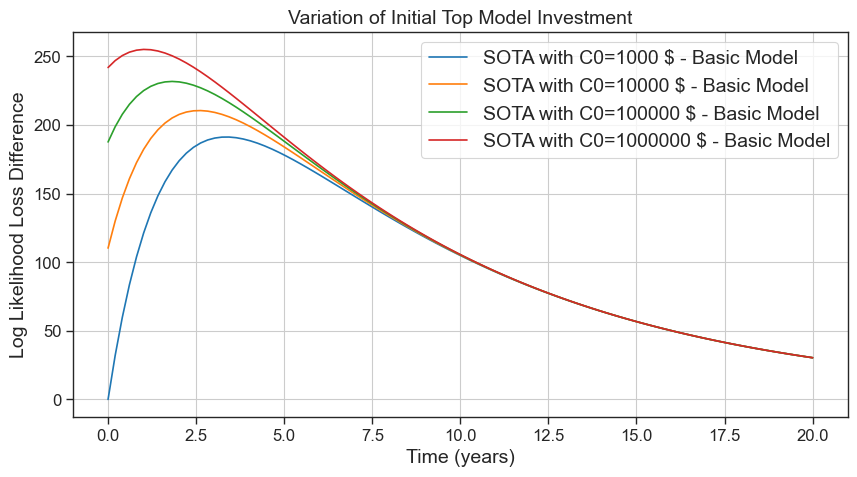

In [421]:
#part of robustness analysis look at different starting captial scenarios
# Plot of overhang over time
time = np.linspace(0, 20, 100)

# i want them all to be on the same graph

plt.figure(figsize=(10, 5))
for start_capital in [1000, 10000, 100000, 1000000]:
    basic_capital = 1000
    # sota_compute_growth = 5 # model compute is growing at 5 times a year 
    # player2_growth = 1.1
    sota_loss = total_loss(start_capital * (sota_compute_growth) ** time, time)
    basic_model_loss = total_loss(basic_capital, time)
    plt.plot(
        time,  basic_model_loss-sota_loss, label=f"SOTA with C0={start_capital} $ - Basic Model")
# add description 
#adjust font sizes
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(prop={'size': 14})
# add description to plot
plt.title("Variation of Initial Top Model Investment", fontsize=14)
plt.xlabel("Time (years)", fontsize=14)
plt.legend(fontsize=14)
plt.ylabel("Log Likelihood Loss Difference", fontsize=14)
plt.grid(True)
#save image to paper images
plt.savefig("Figures/variation_initial_investment.png")


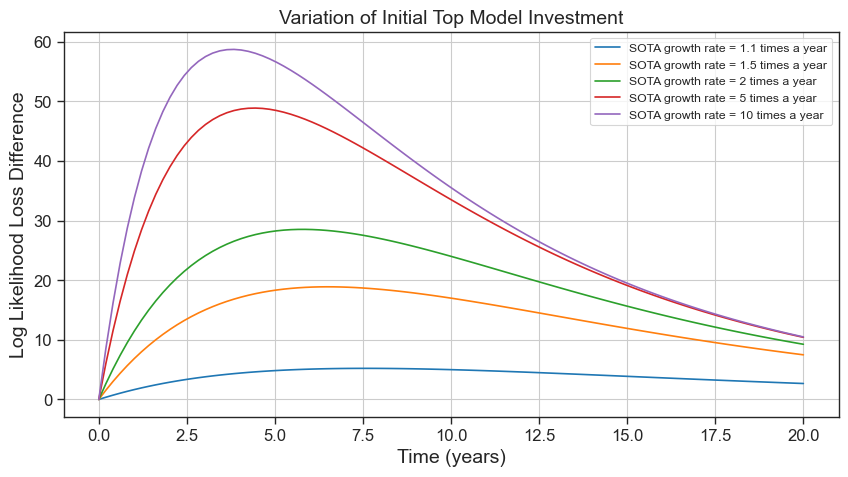

In [422]:
#model configuring various levels of compute growth 
#first look at variation with variation in shared growth factor 
time = np.linspace(0, 20, 100)
plt.figure(figsize=(10, 5))
for sota_compute_growth in [1.1, 1.5, 2, 5, 10]:
    # both models start with an initial captial of 1000 dollars
    sota_loss = total_loss(start_capital * (sota_compute_growth) ** time, time)
    basic_model_loss = total_loss(start_capital, time)
    plt.plot(
        time, basic_model_loss - sota_loss, label=f"SOTA growth rate = {sota_compute_growth} times a year")
# add description 
# add description to plot
plt.title("Variation of Initial Top Model Investment", fontsize=14)
plt.xlabel("Time (years)", fontsize=14)
plt.legend()
plt.ylabel("Log Likelihood Loss Difference", fontsize=14)
plt.grid(True)
#adjust font sizes
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend()

#save image to paper images
plt.savefig("Figures/variation_sota_growth.png")


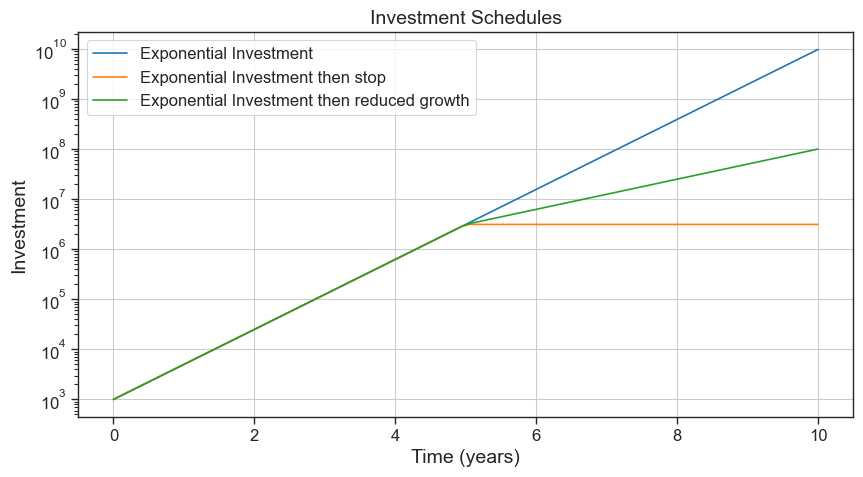

In [423]:
# look at different investment curves over time for top model 
#ie regular exponential 
#logistic
#exponential then stop 
#exponential then reduced exponential growth

time = np.linspace(0, 10, 100)
plt.figure(figsize=(10, 5))
# logistic_investment = lambda time: 1000 + 1e10/ (1 + 1e11*np.exp(-np.log(5)* (time+5)))
exponential_investment = lambda time: 1000 * (5) ** time
exponential_stop_investment = lambda time: 1000 * (5) ** time if time < 5 else 1000 * (5) ** 5
#map exponential investment onto time array
exponential_stop_investment = list(map(exponential_stop_investment, time))
exponential_reduce_investment = lambda time: 1000 * (5) ** time if time < 5 else 1000 * (5) ** 5 * (2) ** (time-5)
#map exponential reduce investment onto time array
exponential_reduce_investment = list(map(exponential_reduce_investment, time))
# plt.plot(time, logistic_investment(time), label="Logistic Investment")
plt.plot(time, exponential_investment(time), label="Exponential Investment")
plt.plot(time, exponential_stop_investment, label="Exponential Investment then stop")
plt.plot(time, exponential_reduce_investment, label="Exponential Investment then reduced growth")
plt.legend()
plt.yscale("log")
plt.grid(True)
plt.legend(fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Time (years)", fontsize=14)
plt.ylabel("Investment", fontsize=14)
plt.title("Investment Schedules", fontsize=14)
plt.savefig("Figures/variation_investment_curves.png")

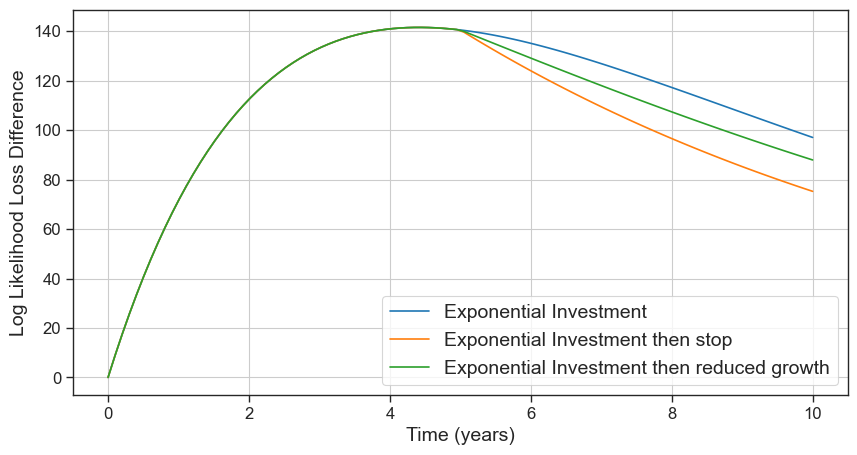

In [375]:
#now look at model trends under each of these investment scenarios
time = np.linspace(0, 10, 100)
plt.figure(figsize=(10, 5))
loss_diff_exponential = -(total_loss(exponential_investment(time), time) - total_loss(1000, time))
loss_diff_exponential_stop = -(total_loss(exponential_stop_investment, time) - total_loss(1000, time))
loss_diff_exponential_reduce = -(total_loss(exponential_reduce_investment, time) - total_loss(1000, time))
plt.plot(time, loss_diff_exponential, label="Exponential Investment")
plt.plot(time, loss_diff_exponential_stop, label="Exponential Investment then stop")
plt.plot(time, loss_diff_exponential_reduce, label="Exponential Investment then reduced growth")
plt.legend()
plt.xlabel("Time (years)")
plt.ylabel("Log Likelihood Loss Difference")
plt.grid(True)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(prop={'size': 14})
plt.xlabel("Time (years)", fontsize=14)
plt.ylabel("Log Likelihood Loss Difference", fontsize=14)
plt.savefig("Figures/variation_investment_curves_loss_diff.png")


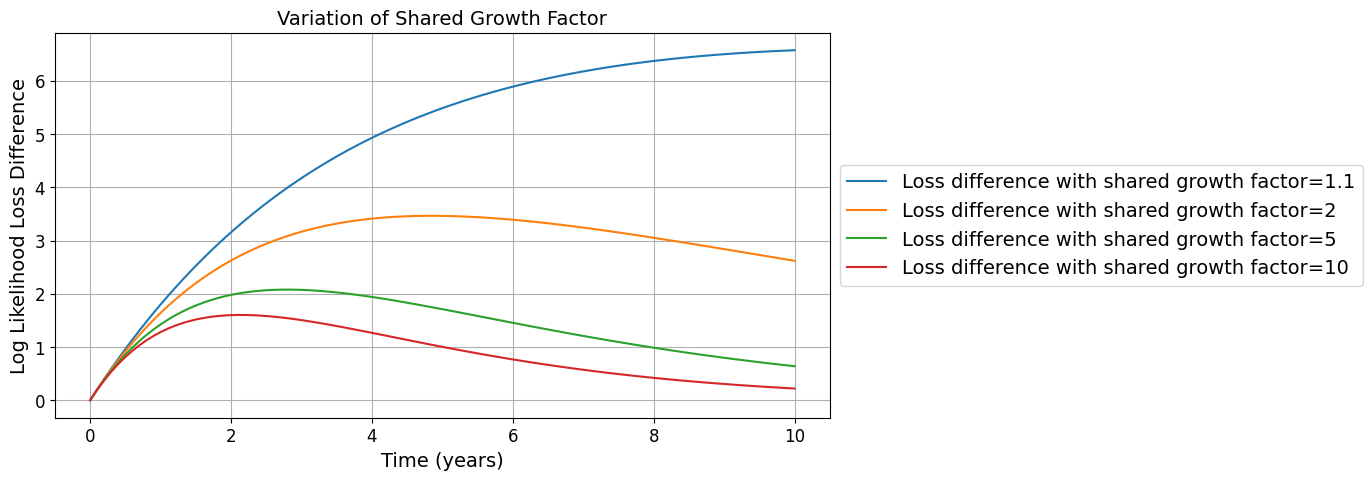

In [11]:
#look at variation in shared growth factor 
time = np.linspace(0, 10, 100)
plt.figure(figsize=(10, 5))
for shared_growth in [1.1, 2, 5, 10]:
    consumer_capital = 1000
    top_capital = 1000
    model_capital_growth = 5
    loss_diff = loss_full_function(top_capital, time, alg_gains=shared_growth, hardware_gains=1, investment_growth=5) - loss_full_function(consumer_capital, time, alg_gains=shared_growth, hardware_gains=1)
    loss_diff = -loss_diff
    plt.plot(
        time, loss_diff, label=f"Loss difference with shared growth factor={shared_growth}")
plt.grid(True)
plt.legend()
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),prop={'size': 14})
plt.xlabel("Time (years)", fontsize=14)
plt.ylabel("Log Likelihood Loss Difference", fontsize=14)
plt.title("Variation of Shared Growth Factor", fontsize=14)
plt.savefig("Figures/variation_shared_growth.png", bbox_inches='tight')
plt.show()

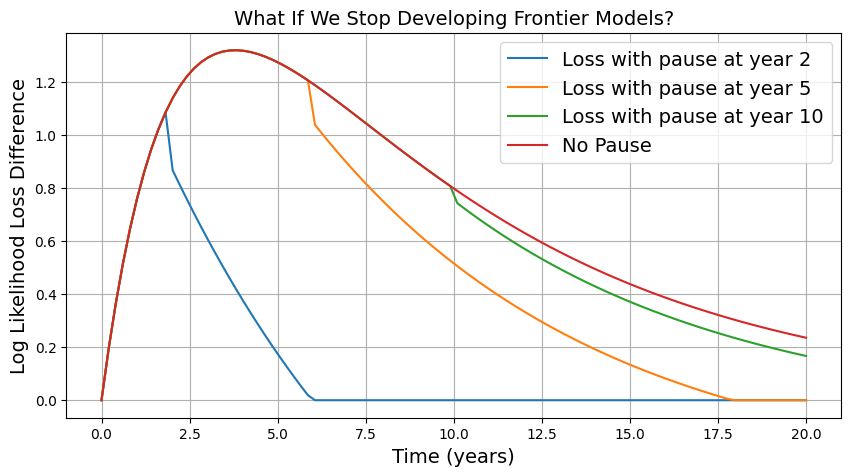

In [12]:
#trying to model AI pauses and overhang period 
#Plot the overhang when model progress is paused
times = np.linspace(0, 20, 100)
plt.figure(figsize=(10, 5))
#compute loss with exponential investment upto time  t
initial_loss = total_loss(1000 * (player1_growth) ** time, time)
#plot this for serval pause-times
# pause_time = 5
def pause_loss(pause_time):
    loss = []
    for time in times:
        
        if time < pause_time:
            pre_pause_loss_diff = total_loss(start_capital, time)-total_loss(start_capital * (sota_compute_growth) ** time, time)
            loss.append(pre_pause_loss_diff)
        else:
            sota_loss = total_loss(start_capital* (player1_growth) ** pause_time, pause_time) 
            pause_loss_diff = total_loss(start_capital, time) -sota_loss
            if pause_loss_diff <0:
                loss.append(0)
            else:
                loss.append(pause_loss_diff)
    loss  = np.array(loss)
    return loss

plt.plot(times, pause_loss(pause_time=2), label="Loss with pause at year 2")
plt.plot(times, pause_loss(pause_time=6), label="Loss with pause at year 5")
plt.plot(times, pause_loss(pause_time=10), label="Loss with pause at year 10")
# plt.plot(times, pause_loss(pause_time=100), label="Loss with pause at year 100")
plt.plot(times, pause_loss(pause_time=1e7), label="No Pause")
plt.title("What If We Stop Developing Frontier Models?", fontsize=14)
plt.xlabel("Time (years)", fontsize=14)
plt.ylabel("Log Likelihood Loss Difference", fontsize=14)
plt.grid(True)
plt.legend(fontsize=14)
plt.savefig("Figures/variation_pause_time.png")
plt.show()


# Modeling Inference Inequality

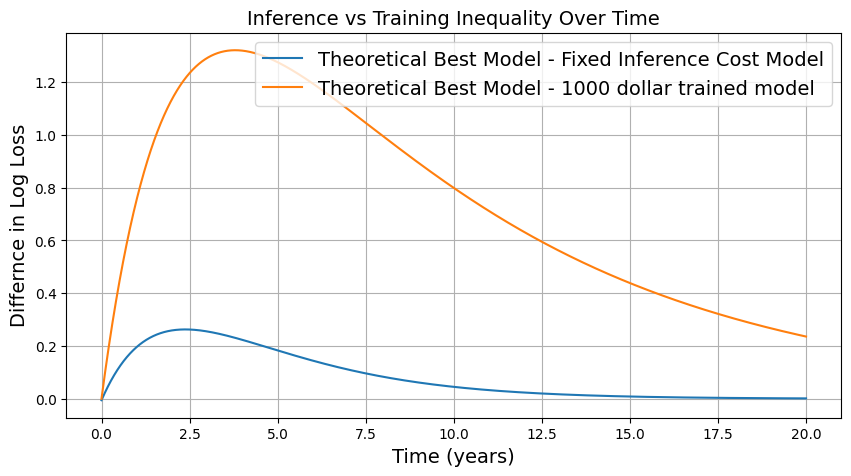

In [13]:

#Model of Inference Inequality Over Time
time = np.linspace(0, 20, 10000)
# Plot inference overhang and training overhang at the same time
sota_loss = total_loss(start_capital* (sota_compute_growth) ** time, time)
basic_loss = total_loss(start_capital, time)
# computer inference cost of model that uses 1000 dollars of training
# infcost0 = 
plt.figure(figsize=(10, 5))
plt.plot(time, total_loss_inf(.0045, time)-sota_loss, label="Theoretical Best Model - Fixed Inference Cost Model")
plt.plot(time, basic_loss-sota_loss, label="Theoretical Best Model - 1000 dollar trained model")
plt.xlabel("Time (years)", fontsize=14)
plt.ylabel("Differnce in Log Loss", fontsize=14)
plt.legend(fontsize=14)
plt.title("Inference vs Training Inequality Over Time", fontsize=14)
plt.grid(True)
plt.savefig("Figures/loss_diff_inference.png")
plt.show()


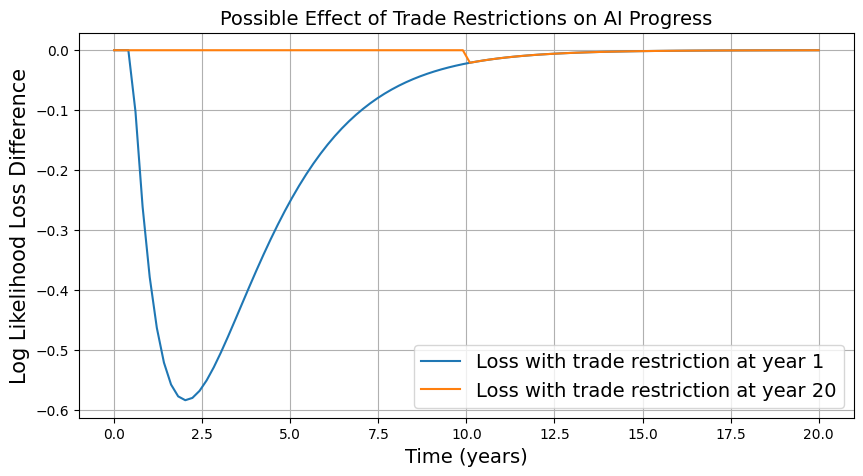

In [14]:
#same model as above with some restore time 
plt.figure(figsize=(10, 5))
#compute loss with exponential investment upto time  t
# intitial_loss = total_loss(1000 * (player1_growth) ** time, time)
#plot this for serval pause-times
trade_restrict_time = 1
restore_time = 5
player1_growth = 5
player2_growth = 5
def hardware_restrict(pause_time, restore_time):
    loss = []
    times = np.linspace(0, 40, 100)
    for time in times:
        bestloss = total_loss(1000 * (player1_growth) **  time, time) 
        if time < pause_time:
            # player2growth = 5.0
            loss.append(total_loss(1000 * (player1_growth) ** time, time)- total_loss(1000* (player2_growth)**time, time))
            # loss.append(5)
       
        elif time < restore_time:
            newplayer2growth = 5.0/1.8
            compute_at_restrict = 1000 * (player2_growth) ** trade_restrict_time
            pause_loss = bestloss - total_loss(compute_at_restrict*(newplayer2growth**(time-trade_restrict_time)), time)
            # consumer_loss = total_loss(1000, time)
            # if pause_loss >0 or bestloss < 2.5 or consumer_loss < 2.5:
            # if pause_loss >0:
            #     loss.append(0)
            # else:
            loss.append(pause_loss)
        else:
            compute_at_restrict = 1000 * (player2_growth) ** trade_restrict_time
            compute_at_restore = compute_at_restrict*(5.0/1.8)**(restore_time-trade_restrict_time)
            loss.append(bestloss - total_loss(compute_at_restore*(5.0**(time-restore_time)), time))


    loss  = np.array(loss)
    return loss
# times
# hardware_restrict(trade_restrict_time)
# #plot results
plt.plot(times, hardware_restrict(1, 1000), label="Loss with trade restriction at year 1")
plt.plot(times,hardware_restrict(20, 1000), label="Loss with trade restriction at year 20")

plt.xlabel("Time (years)", fontsize=14)
plt.grid(True)
plt.ylabel("Log Likelihood Loss Difference", fontsize=15)
plt.title("Possible Effect of Trade Restrictions on AI Progress", fontsize=14)
plt.legend(fontsize=14)
# player2growth = 2.0
# plt.plot(times,total_loss(1000 * (player1_growth) ** times, times)- total_loss(1000* (player2growth)**times, times))
plt.savefig("Figures/trade_restrictions.png")

Text(0.5, 1.0, 'Gap at t=10 years')

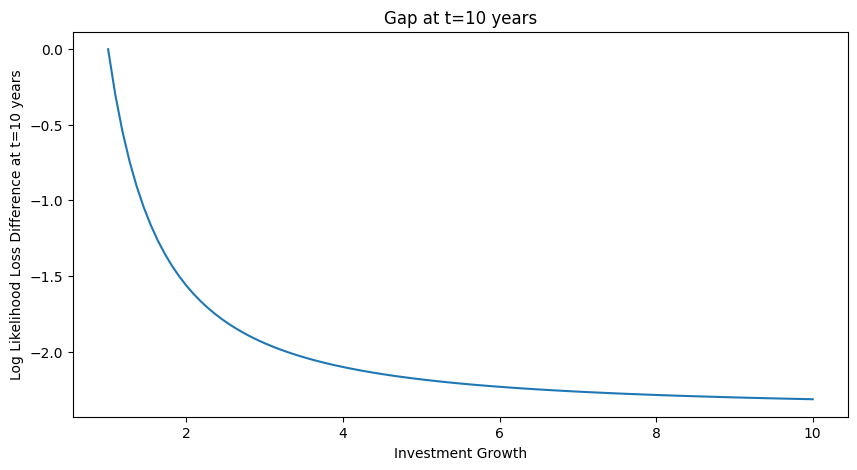

In [15]:
#now set t  constant and vary g_invest
time = 10
#numericlaly solve for the minium of overhang function
g_invest = np.linspace(1, 10, 100)
loss = total_loss(1000 * g_invest ** time, time)-total_loss(1000, time)
plt.figure(figsize=(10, 5))
plt.plot(g_invest, loss, label="Loss")
plt.xlabel("Investment Growth")
plt.ylabel("Log Likelihood Loss Difference at t=10 years")
plt.title("Gap at t=10 years")

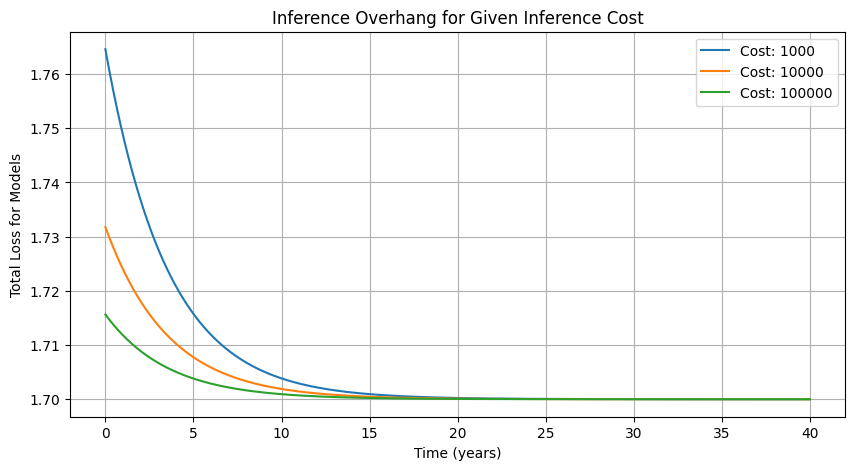

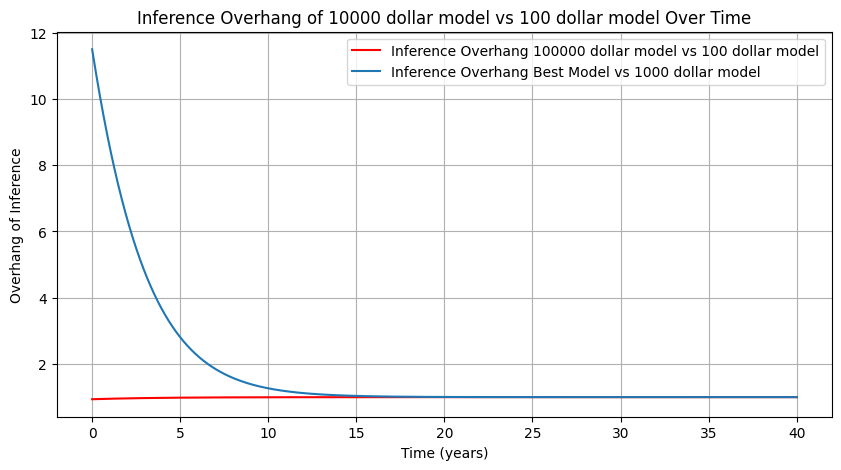

In [16]:

alg_gains_inf = 2
alg_gains = 2
total_loss_inf = lambda cost, time: chin_func(
    (
        ((flops_per_dollar_year0*cost)**2)/ (cost_per_flop_year**(2*time))
        * (alg_gains**time)*(alg_gains_inf**time)
      
    )
)

# total_loss = lambda cost, time: chin_func(
#     (alg_gains**time) * flops_per_dollar_year0 * cost / (cost_per_flop_year**time)
# )

time = np.linspace(0, 40, 10000)
plt.figure(figsize=(10, 5))
for c in [1000, 10000, 100000]:
    loss = total_loss_inf(c, time)
    plt.plot(time, loss, label=f"Cost: {c}")

best_loss_seq = total_loss(1 * (player1_growth) ** time, time)
inf_overhang = total_loss_inf(100000, time) / total_loss_inf(100, time)
inf_bestvs1000dollars = best_loss_seq / total_loss_inf(1, time)

plt.ylabel("Total Loss for Models")
plt.xlabel("Time (years)")
plt.title("Inference Overhang for Given Inference Cost")
plt.legend()
plt.grid(True)

plt.figure(figsize=(10, 5))
plt.plot(
    time,
    inf_overhang,
    "r",
    label="Inference Overhang 100000 dollar model vs 100 dollar model",
)
plt.plot(
    time,
    inf_bestvs1000dollars,
    label="Inference Overhang Best Model vs 1000 dollar model",
)

plt.title("Inference Overhang of 10000 dollar model vs 100 dollar model Over Time")
plt.xlabel("Time (years)")
plt.ylabel("Overhang of Inference")
plt.legend()
plt.grid(True)


In [17]:
# # loook at differene in loss/perplexity over time
# plt.figure(figsize=(10, 5))
# plt.plot(time, player1loss - total_loss(1000, time), label="Difference in loss")
# plt.plot(
#     time, player1loss - player2loss, label="Difference in loss between best and second best"
# # )

In [18]:
plt.plot(time, player1loss-loss_const_param(time, param=const_params),label=f"Theoretical Best Model - billion param model with Infinite Data")
plt.xlabel("Time (years)")
plt.ylabel("Differnce in Log Loss")
plt.legend()
plt.title("Const Param Model vs Theoretical Best Model")
plt.grid(True)
#save figure
plt.savefig("Figures/loss_diff_const_param.png")

NameError: name 'loss_const_param' is not defined

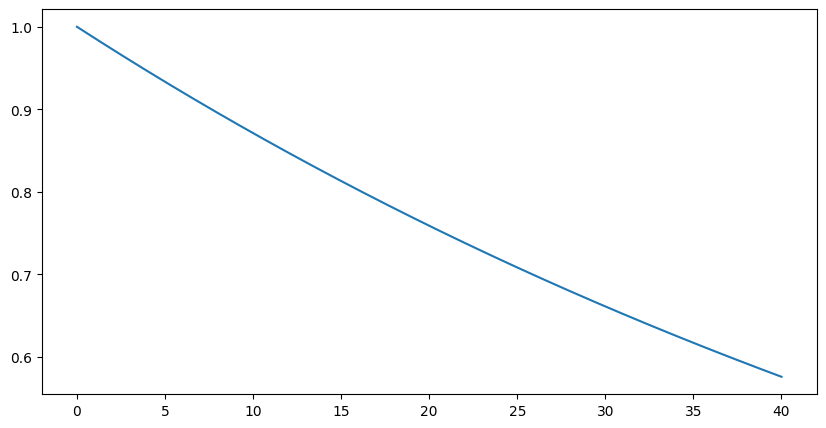

In [ ]:
#TODO Another model of inference overhang assuming fixed parameters for better and base model


/var/folders/lp/hk0h_6g94b59251kmlwhp32h0000gn/T/ipykernel_31974/3707354998.py:6: RuntimeWarning: divide by zero encountered in log
  y = (1/b)*np.log(np.log(g)/np.log(g*x))*(np.log(x))**-1


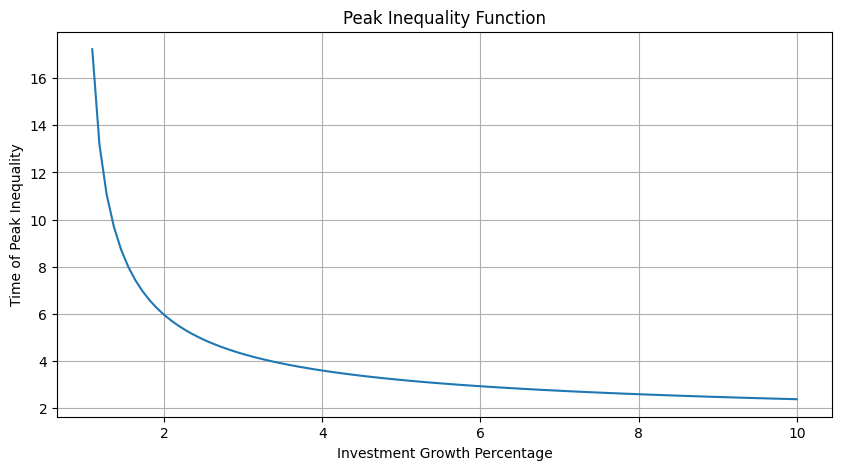

In [30]:
# graph the time of overhang function 
g = np.linspace(1, 10, 100)
#logarithm python
x = 1.8*1.4
b = -0.154
y = (1/b)*np.log(np.log(g)/np.log(g*x))*(np.log(x))**-1
plt.figure(figsize=(10, 5))
plt.plot(g, y)
plt.ylabel("Time of Peak Inequality")
plt.xlabel("Investment Growth Percentage")
plt.title("Peak Inequality Function")
plt.grid(True)

In [31]:
# # comparign models with constant parameters
# upper_param = 1e2
# lower_param = 1e69
# # loss = loss_const_param(time, param=const_params)
# plt.figure(figsize=(10, 5))
# plt.plot(time,loss_const_param(time, param=upper_param)/loss_const_param(time, param=lower_param),  label="Constant Parameter Comparison")

Text(0.5, 1.0, 'Possible Effect of Trade Restrictions on AI Progress')

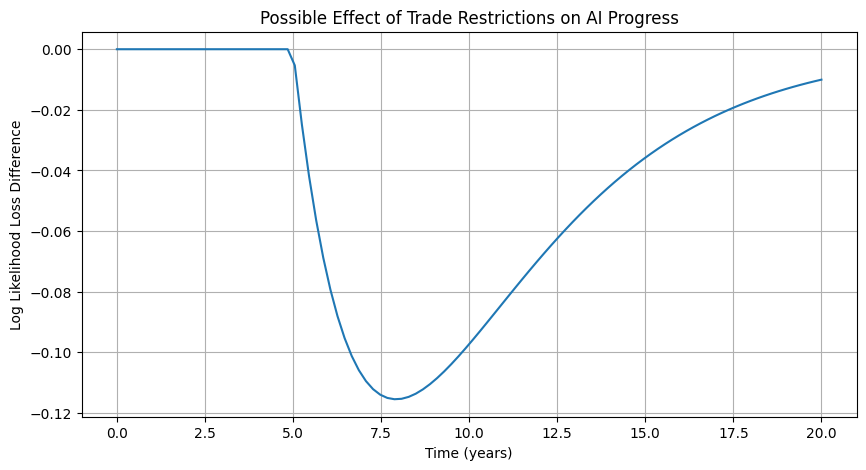

In [32]:
# model of competition when one player has suddently reduced hardware growth 
#trying to model AI pauses and overhang period 
#Plot the overhang when model progress is paused
# import numpy as np

plt.figure(figsize=(10, 5))
#compute loss with exponential investment upto time  t
# intitial_loss = total_loss(1000 * (player1_growth) ** time, time)
#plot this for serval pause-times
trade_restrict_time = 5
restore_time = 15
player1_growth = 5
player2_growth = 5
def hardware_restrict(pause_time):
    loss = []
    times = np.linspace(0, 20, 100)
    for time in times:
        if time < trade_restrict_time:
            # player2growth = 5.0
            loss.append(total_loss(1000 * (player1_growth) ** time, time)- total_loss(1000* (player2_growth)**time, time))
            # loss.append(5)
        else:
            newplayer2growth = 5.0/1.8
            bestloss = total_loss(1000 * (player1_growth) **  time, time) 
            compute_at_restrict = 1000 * (player2_growth) ** trade_restrict_time
            pause_loss = bestloss - total_loss(compute_at_restrict*(newplayer2growth**(time-trade_restrict_time)), time)
            # consumer_loss = total_loss(1000, time)
            # if pause_loss >0 or bestloss < 2.5 or consumer_loss < 2.5:
            # if pause_loss >0:
            #     loss.append(0)
            # else:
            loss.append(pause_loss)
    loss  = np.array(loss)
    return loss
# times
hardware_restrict(trade_restrict_time)
# #plot results
plt.plot(times, hardware_restrict(trade_restrict_time), label="Loss with trade restriction at year 5")
plt.xlabel("Time (years)")
plt.grid(True)
plt.ylabel("Log Likelihood Loss Difference")
plt.title("Possible Effect of Trade Restrictions on AI Progress")
# player2growth = 2.0
# plt.plot(times,total_loss(1000 * (player1_growth) ** times, times)- total_loss(1000* (player2growth)**times, times))

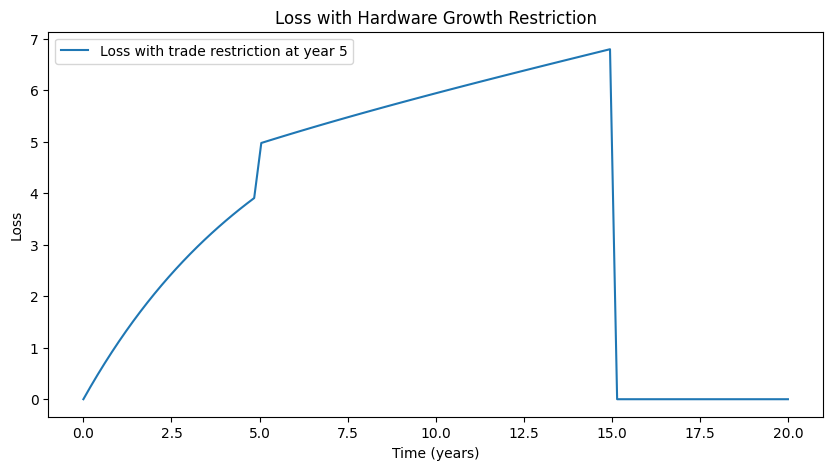

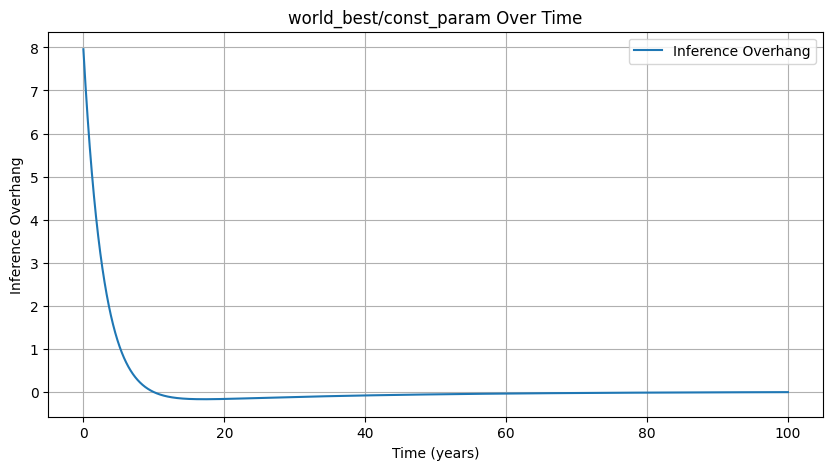

In [33]:
# Inference overhang for constant parameter models
time = np.linspace(0, 100, 10000)
cost_per_flop_year = 1
loss_constant = 1.7
const_params = 1e9
A = 406.4
alpha_year = -0.035
loss_const_param = (
    lambda time, param: loss_constant + A *(2.718**(alpha_year*time)) / (param) ** 0.34
)
plt.figure(figsize=(10, 5))
plt.xlabel("Time (years)")
plt.ylabel("Inference Overhang")
world_loss_seq = total_loss(1000 * (player1_growth) ** time, time)
loss_infoptimal_year_seq = loss_const_param(time, param=const_params)
plt.plot(time, world_loss_seq-loss_infoptimal_year_seq, label="Inference Overhang")
plt.title("world_best/const_param Over Time")
plt.legend()
plt.grid(True)
plt.savefig("Figures/world_best_const_param.png")


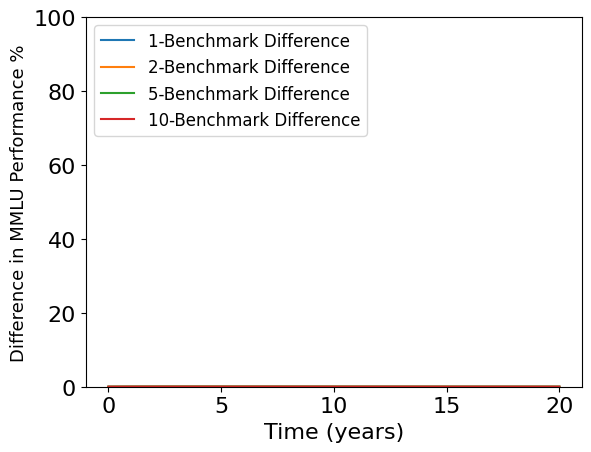

In [ ]:
# Benchmark Performance of the Model 
# L = 0.5566859825577314
# x0 = 1.9739480423345785
# k = -23.774928114776312
# b = 0.2540434458699578
consecutive_tasks = 5
small_p = 2

def loss_to_benchmark(x, k=-23.77, x0=1.97, L=0.55, b=0.25):
    return L/(1 + np.exp(-k*(x-x0))) + b

time = np.linspace(0, 20, 100)
y1 = loss_to_benchmark(total_loss(flop_year_zero * (sota_compute_growth) ** time, time))
y2 = loss_to_benchmark(total_loss(flop_year_zero, time))
y3 = y2**consecutive_tasks-y1**consecutive_tasks
y4 = y2-y1
y5 = y2**small_p-y1**small_p
y10 = y2**10-y1**10
# plt.plot(x, y1, label='sigmoid(x)')
# plt.plot(x, y2, label='sigmoid(2*x)')
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.xticks(np.arange(0, 21, 5), fontsize=16)
plt.plot(time, -y4*100, label='1-Benchmark Difference')
plt.plot(time, -y5*100, label=f'{small_p}-Benchmark Difference')
plt.plot(time, -y3*100, label=f'{consecutive_tasks}-Benchmark Difference')
plt.plot(time, -y10*100, label=f'10-Benchmark Difference')
# plt.legend(loc='center', bbox_to_anchor=(0.5, -0.2), ncol=3, fontsize=12)
plt.legend(loc='upper left', fontsize=12)

plt.yticks(fontsize=16)
plt.xscale('linear')
plt.xlabel("Time (years)", fontsize=16)
plt.ylabel("Difference in MMLU Performance %", fontsize=13)
plt.ylim(0, 100)
plt.xticks(np.arange(0, 21, 5), fontsize=16)
# plt.grid(True)
plt.savefig("Figures/benchmark_performance.png")

[ 0  5 10 15 20]


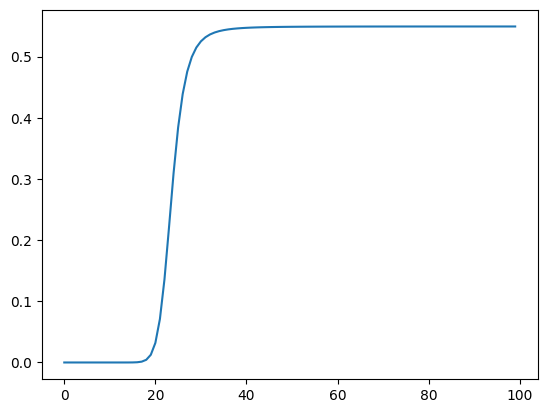

In [156]:
# graph the two sigmoides
print( np.arange(0, 21, 5))
y1 = sigmoid(total_loss(start_capital * (sota_compute_growth) ** time, time))
y2 = sigmoid(total_loss(start_capital, time))
plt.plot(y1)


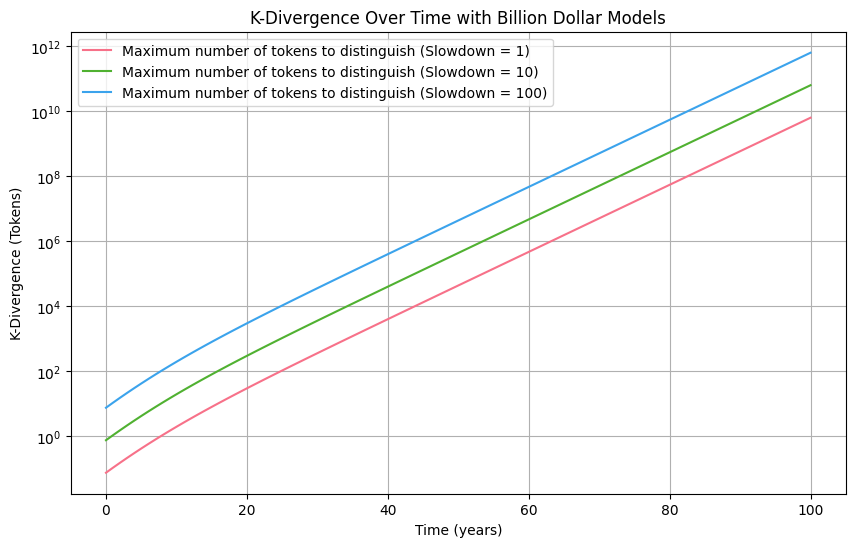

In [16]:
# Look at K-Divergence between models 
def upper_k_divergence(time, slowdown=1):
    intermed = (loss_full_function(1e3, time, investment_growth=2)-1.7)**.5+(loss_full_function(1e3, time, investment_growth=10)-1.7)**.5
    return slowdown*2.535*(intermed)**-2
# def lower_k_divergence(time, slowdown=1):
#     return slowdown*2.535*(loss_full_function(1e3, time)+loss_full_function(1e3, time, investment_growth=1.8))**-1

x = np.linspace(0, 100, 100)
# y = k_divergence(x, slowdown=1)
# plt.plot(x, y)
#plot for other slowdown factors
# colors = plt.cm.viridis(np.linspace(0, 1, 3))  # 3 distinct color
# colors = ['red', 'blue', 'green']
#seaborn 

sns.set_palette("husl")

colors = sns.color_palette("husl", 3)
plt.figure(figsize=(10, 6))
for i, slowdown in enumerate([1, 10, 100]):
    color = colors[i]
    y_upper = upper_k_divergence(x, slowdown=slowdown)
    # y_lower = lower_k_divergence(x, slowdown=slowdown)
    
    plt.plot(x, y_upper, color=color, linestyle='-', label=f"Maximum number of tokens to distinguish (Slowdown = {slowdown})")
    # plt.plot(x, y_lower, color=color, linestyle='--', label=f"Lower bound (Slowdown = {slowdown})")

plt.xlabel("Time (years)")
plt.ylabel("K-Divergence (Tokens)")
plt.grid(True)
plt.legend()
plt.yscale('log')
plt.title("K-Divergence Over Time with Billion Dollar Models")
plt.savefig("Figures/k_divergence.png")

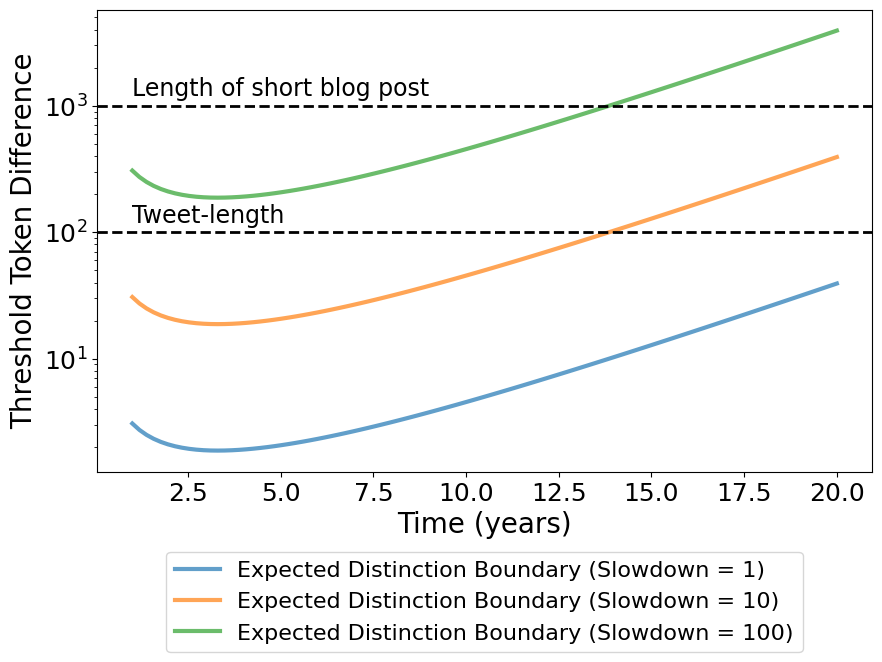

In [121]:
# now look at upper and lower bounds based on TV divergence 
epsilon = 1e-2 # lower bound on error of hypothesis testing
slowdowns = [1, 10, 100]
D1 = lambda time: loss_full_function(1e3, time, investment_growth=2)-1.7
D2 = lambda time: loss_full_function(1e3, time, investment_growth=5)-1.7
# upper_bound = lambda time, slowdown: slowdown*2*(1-epsilon)**2*((D1(time)/2)-(D2(time)/2))**-1
upper_bound = lambda time, slowdown: slowdown*2.65*((D1(time)-D2(time))**-1)

x = np.linspace(1, 20, 100)
plt.figure(figsize=(10, 6))
plt.rcParams['font.family'] = 'DejaVu Sans'
for slowdown in slowdowns:
    y_upper = upper_bound(x, slowdown)
    plt.plot(x, y_upper, label=f"Expected Distinction Boundary (Slowdown = {slowdown})", linewidth=3, alpha=0.7)

plt.axhline(y=1e3, color='black', linestyle='--', linewidth=2)
plt.text(1, 1.2e3, 'Length of short blog post', fontsize=17)

plt.axhline(y=1e2, color='black', linestyle='--', linewidth=2)
plt.text(1, 1.2e2, 'Tweet-length', fontsize=17)

plt.xlabel("Time (years)", fontsize=20)
plt.ylabel("Threshold Token Difference", fontsize=20)
# plt.grid(True)
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.legend(fontsize=16, bbox_to_anchor=(0.5, -0.15), loc='upper center')
# plt.title("Number of Tokens Necessary to Distinguish Models for Various Slowdowns", fontsize=14, fontweight='bold')
plt.yscale('log')
plt.savefig("Figures/growth_token_distinction_boundary.png", bbox_inches='tight')


/var/folders/lp/hk0h_6g94b59251kmlwhp32h0000gn/T/ipykernel_80528/3243454683.py:11: RuntimeWarning: overflow encountered in multiply
  (alg_gains**time) * flops_per_dollar_year0 * investment*(investment_growth**time)* (hardware_gains**time)
/var/folders/lp/hk0h_6g94b59251kmlwhp32h0000gn/T/ipykernel_80528/3243454683.py:11: RuntimeWarning: overflow encountered in power
  (alg_gains**time) * flops_per_dollar_year0 * investment*(investment_growth**time)* (hardware_gains**time)


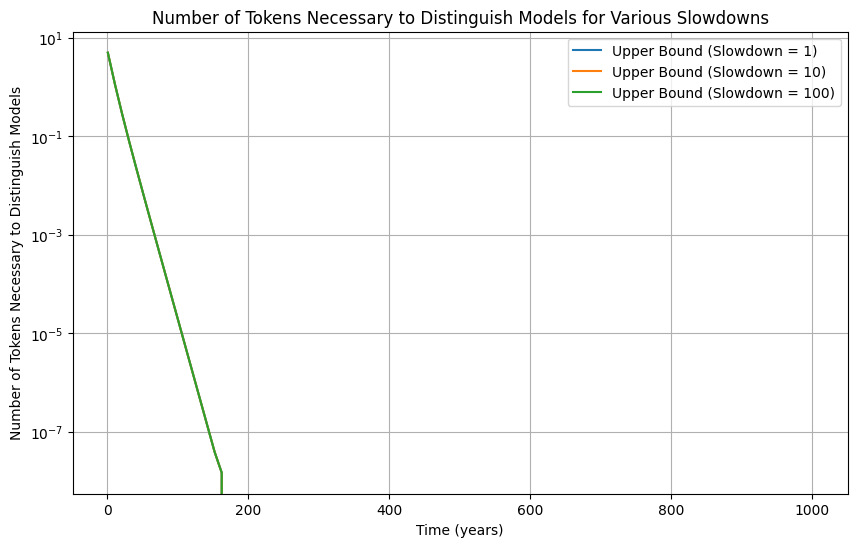

In [21]:
psilon = 1e-2 # lower bound on error of hypothesis testing
slowdowns = [1, 10, 100]
D1 = lambda time: loss_full_function(1e3, time, investment_growth=2)-1.7
D2 = lambda time: loss_full_function(1e3, time, investment_growth=5)-1.7
upper_bound = lambda time, slowdown: (D1(time)**.5 +D2(time)**.5)

x = np.linspace(1, 1000, 100)
plt.figure(figsize=(10, 6))
for slowdown in slowdowns:
    y_upper = upper_bound(x, slowdown)
    plt.plot(x, y_upper, label=f"Upper Bound (Slowdown = {slowdown})")

plt.xlabel("Time (years)")
plt.ylabel("Number of Tokens Necessary to Distinguish Models")
plt.grid(True)
plt.legend()
plt.title("Number of Tokens Necessary to Distinguish Models for Various Slowdowns")
plt.savefig("Figures/tv_divergence_test.png")
plt.yscale('log')

91.55542534161572


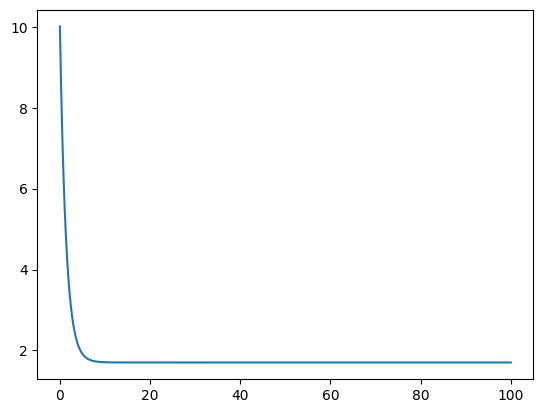

In [61]:
#graph the loss function over time 
loss_full_function(1000, time, investment_growth=50)
plt.plot(time, loss_full_function(1000, time, investment_growth=50))

print(2.35/(1070*(1e30)**-0.154))